# ISAAC

### Skilgreiningar á undirsöfnum

In [1]:
import sys
sys.path.insert(0, 'C:\\Users\\Lenovo\\Documents\\Isaac\\traderar\\')

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from matplotlib import pyplot as plt
from a_earnings_trader20200125 import earnings_trader
from b_volume_trader20200125 import volume_trader
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import stats
import scipy.cluster.hierarchy as hac
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import shap
from alibi.explainers import KernelShap
from mlxtend.plotting import scatterplotmatrix
from sklearn.decomposition import PCA

### Gögn sótt á Nasdaq með ET og VT

In [2]:
et = earnings_trader()
et.fetch_data(
    from_database=False,
    ref_price='Adj close price day of release',
)
market_reactionsdf = et.market_reactions_df
market_reactionsdf = market_reactionsdf.fillna(method="bfill", axis="index")

dagarAðExiti=40
thröskuldur=dagarAðExiti/1100

market_reactionsdf["exit"] = market_reactionsdf[dagarAðExiti] - market_reactionsdf[3]

vt = volume_trader()
vt.fetch_data(
    from_database=False,
    ref_price='Adj close price day of release',
)
vt_df = vt.market_reactions_df
vt_df = vt_df.fillna(vt_df.mean(axis=1))




X=pd.concat([market_reactionsdf[-10],market_reactionsdf[-30],\
             market_reactionsdf[-270],market_reactionsdf[3],\
             vt_df[-3]+vt_df[-2]+vt_df[-1],vt_df[1]+vt_df[2]+vt_df[3],\
             et.option_prices['call_pr']\
             ,market_reactionsdf["exit"]], axis=1, join='inner')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Skilgreining á tveimur föllum, hagnaði og greinariti

Föllin sem við skilgreinum hér eru annars vegar hagnaðarfallið profit sem notað er til að reikna meðalhagnað af stöðum í tests safninu.

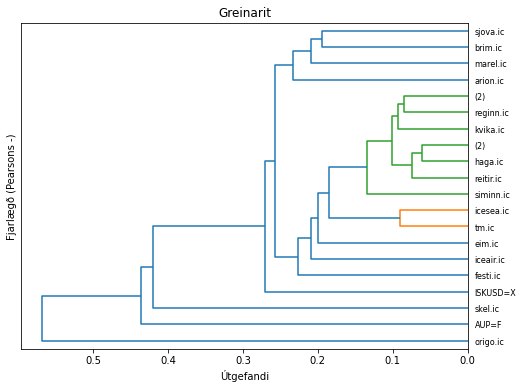

In [3]:
def profit(u_test, y_pred):
    sum = 0
    sumlist = []
    for i in range(len(u_test)):
        if y_pred[i] == 1:
            sum = sum + max(u_test[i] - thröskuldur, 0) * 10
            sumlist.append(y_pred[i])
        elif y_pred[i] == 2:
            sum = sum + max(-u_test[i] - thröskuldur, 0) * 10
            sumlist.append(y_pred[i])

    print("******hagnaður*****")
    print(sum / len(y_test))
    print("*******************")


def linkage_metric(x, y):
    r = stats.spearmanr(x, y)[0]
    return 1 - r


fig_size = (8, 6)
adj_close = pd.DataFrame()
for stock in list(et.all_df.keys()):
    try:
        temp = et.all_df[stock]['Adj Close']
        if len(temp) > 3:
            temp.name = stock
            adj_close = adj_close.join(temp, how='outer')
        else:
            print('Excluding {} from clustering model'.format(stock))
    except:
        print('Excluding {} from clustering model'.format(stock))
adj_close = adj_close.dropna()

Z = hac.linkage(adj_close.loc['2021-01-01':'2021-01-30'].T,
                method='single',
                metric=linkage_metric)

# Plot dendogram
fig5, ax5 = plt.subplots(figsize=fig_size)
plt.title('Greinarit')
plt.xlabel('Útgefandi')
plt.ylabel('Fjarlægð (Pearsons -)')
hac.dendrogram(
    Z,
    truncate_mode='lastp',
    orientation='left',
    p=20,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=0.15,
    labels=adj_close.columns.tolist(),
)
plt.show()

### Upplýsingar um sölu, framlegð og endurkaup sóttar í árshlutauppgjör og tilkynningar til Nasdaq og samantektir Arev

In [4]:
#Sölu og framlegðarupplýsingar sóttar úr árshlutauppgjörum

path = "C:\\Users\\Lenovo\\Documents\Isaac\\framlegðarútreikningar\\"

file = path + "Framlegðarútreikningar - snyrtir1.xlsx"
xl = pd.ExcelFile(file)
#
## Excel gögnin sett í gagnasöfnin dfSala og dfFramlegð
dfSala = xl.parse('Sala%', index_col='Quarter')

dfFramlegð = xl.parse('Framlegð%', index_col='Quarter')
#
dfEndurkaup = xl.parse('Endurkaupaáætlun', index_col='Quarter')

for c in dfSala.columns:
    for i in dfSala.index:
        # try:
        u = c + "_" + i
        v1 = dfSala.loc[i, c]
        v2 = dfFramlegð.loc[i, c]
        v3 = dfEndurkaup.loc[i, c]
        if v1 != v1:
            X.at[u, "Sala_pr"] = 0
        else:
            X.at[u, "Sala_pr"] = float(v1)
        if v2 != v2:
            X.at[u, "Framl_pr"] = 0
        else:
            X.at[u, "Framl_pr"] = float(v2)
        if v3 != v3:
            X.at[u, "Endurkaup"] = 0
        else:
            X.at[u, "Endurkaup"] = float(v3)

    #except:
    #   pass

Mood = X.loc[X.index.str.contains('', regex=True)]
Mood = pd.DataFrame(Mood[3])

for index, row in X.iterrows():
    try:
        quarter = index[-4:]
        quarter_leq = 'leq.ic_20' + quarter
        X.at[index, "mood"] = Mood.loc[quarter_leq, :][3]
        
        quarter_AUP='AUP=F_20'+quarter
        X.at[index, "AUP"] = Mood.loc[quarter_AUP, :][3]
        quarter_ISKUSD='ISKUSD=X_20'+quarter
        X.at[index, "ISKUSD"] = Mood.loc[quarter_ISKUSD, :][3]
    except:
        print(index)

In [5]:
path = "C:\\Users\\Lenovo\\Documents\Isaac\\data\\"

file = path + "CLI_www_201217.xlsx"
xl = pd.ExcelFile(file)
#
## Excel gögnin sett í gagnasöfnin dfSala og dfFramlegð
dfLeadInd = xl.parse('quarters', index_col='Quarters')
dfLeadInd

for index, row in X.iterrows():
    try:
        quarter = index[-6:]
        X.at[index, "leadInd"] = dfLeadInd.loc[quarter, :]
    except:
        pass

X.rename(columns={
    -10: 'm10',
    -30: 'm30',
    -270: 'm270',
    3: 'm3',
    0: 'vm',
    1: 've'
},
         inplace=True)

In [6]:
et.ud
et.stocks

angelNums_df = pd.read_csv(
    'C://Users//Lenovo//ownCloud/Radgjof//Ráðgjöf//algós//R//Vísitölur//df.csv',
    encoding="UTF-8")

for idx, row in angelNums_df.iterrows():
    dt = datetime.strptime(idx, '%Y-%m-%d').date()
    angelNums_df.at[idx, "angel"] = dt

angelNums_df.set_index('angel')

df = angelNums_df.set_index(pd.DatetimeIndex(angelNums_df['angel']))

In [7]:
for index, row in X.iterrows():
        #find quarter and stock name
    quarter = index[-6:]
    size = len(index)
    stockName = index[:size - 7]
    #find date of announcement
    da = et.ud.loc[stockName][quarter]
    da21 = timedelta(21)
    new_da = da - da21
    #find angelnumber
    u0 = angelNums_df[angelNums_df["angel"] == new_da]
    if u0.empty:
        new_da=new_da+ timedelta(1)
        u0 = angelNums_df[angelNums_df["angel"] == new_da]
        if u0.empty:
            new_da=new_da+ timedelta(1)
            u0 = angelNums_df[angelNums_df["angel"] == new_da]
    u = angelNums_df[angelNums_df["angel"] == da]
    
    location = stockName + "_" + quarter
    try:
        X.at[location,"angel"]=\
        u['verdmaeti_dagsetning,"visitala"'].values[0]/u0['verdmaeti_dagsetning,"visitala"'].values[0]-1
    except:
        pass


### X mengið skilgreint

In [8]:
X_keep = X
X = X.loc[X.index.str.contains('2017|2018|2019|2020', regex=True)]
X = X[X.index.str.contains("leq|AUP|ISKUSD|kvika.ic_2017|arion.ic_2017|\
                               arion.ic_2018Q1|arion.ic_2018Q2|\
                               kvika.ic_2018Q1|2019_Q3|\
                               skel.ic_2016|icesea.ic_2016") == False]




X = X.fillna(0)
X_keep = X_keep.fillna(0)

V = X

#X.sort_values("exit",inplace=True)
Y = X['exit']
del X["exit"]
del X_keep["exit"]


In [9]:
ac_df = pd.DataFrame()

for stock in et.stocks:
    df = et.all_df[stock]
    try:
        ac_df[stock] = df['Adj Close']
    except:
        pass

ac_df.to_csv(
    "C://Users//Lenovo//ownCloud//Radgjof//Ráðgjöf//algós//R//Vísitölur//output.csv",
    index=True)

### Flokkunin á Y undirbúin, samfylgni reiknuð, spáfjórðungur festur

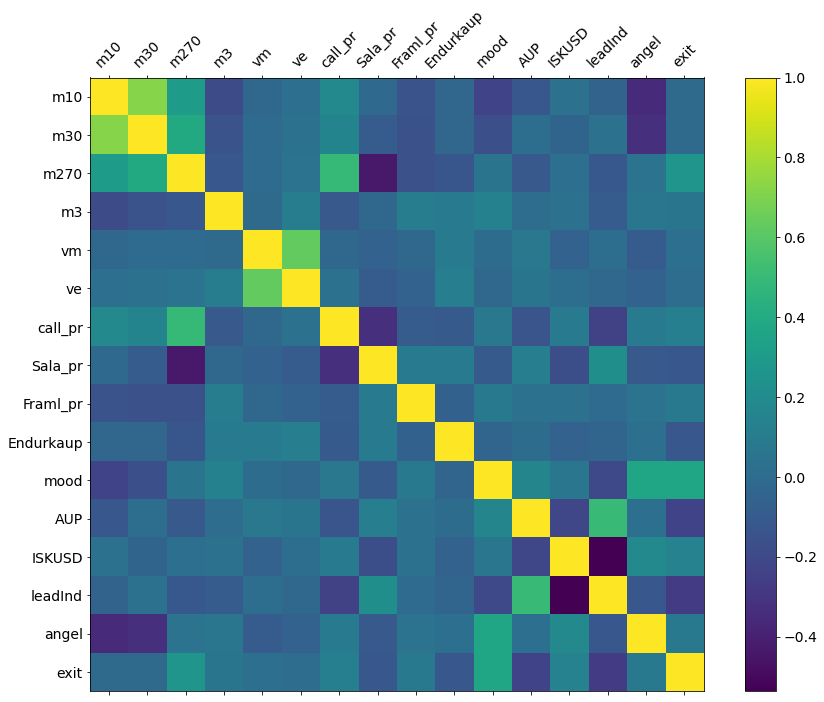

In [10]:
Y1=Y

U=[]
for stak in Y: 
    if stak > 0.05:
        stak = 1

    elif stak<-0.05:
        
        stak = -1
    else:
        stak=0
        
        
    U.append(stak)
Y=U

data= pd.concat([V,Y1], axis=1)
corr=data.corr()    
f = plt.figure(figsize=(15, 11))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)



seed = 2
test_size = 0.3


X_train, X_test, y_train, u_test = train_test_split(X, Y1, test_size=test_size, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed, shuffle=True)

X_test1=X_keep.loc[X_keep.index.str.contains('2021Q1', regex=True)]
X_test1 = X_test1[X_test1.index.str.contains("leq|AUP|ISKUSD") == False]
X_test2=X_test1

feat_labels = X_train.columns



### Samfylgni dálkanna könnuð

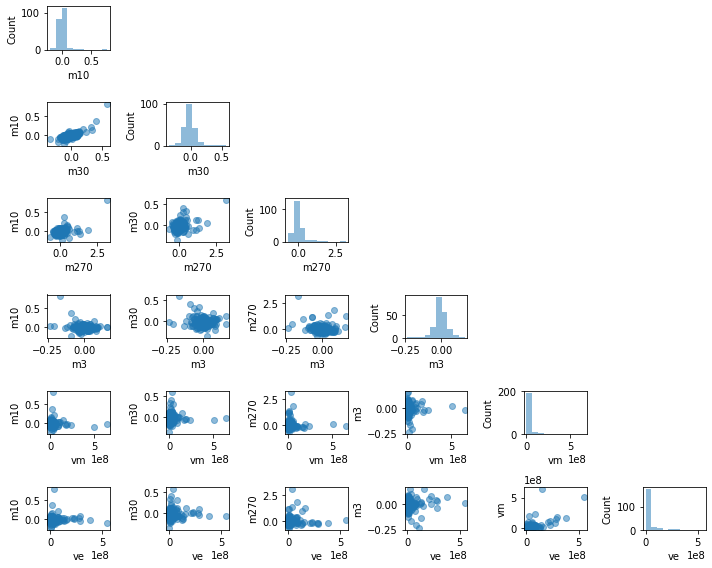

In [11]:
cols = X_train.columns[0:6]

scatterplotmatrix(X_train[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

## Newton flokkarinn (XGB) keyrður

{'colsample_bytree': 0.7, 'eta': 0.2, 'eval_metric': 'merror', 'gamma': 0.5, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 17, 'objective': 'reg:linear', 'subsample': 0.9}
Accuracy: 56.18%


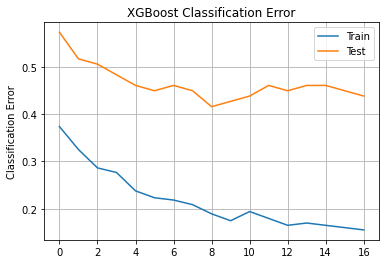

******hagnaður*****
0.3877391582701533
*******************
***********************************************
              precision    recall  f1-score   support

          -1       0.58      0.37      0.45        30
           0       0.48      0.54      0.51        28
           1       0.62      0.77      0.69        31

    accuracy                           0.56        89
   macro avg       0.56      0.56      0.55        89
weighted avg       0.56      0.56      0.55        89

***********************************************


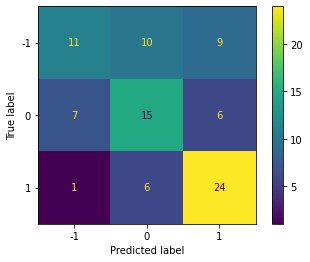

In [22]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtest1 = xgb.DMatrix(X_test1)

model = XGBClassifier(seed=3)

params = {
    'n_estimators': [17],
    'gamma': [ 0.5],
    'max_depth': [3],
    'min_child_weight': [0.5,2, 5],
    'max_delta_step': [0],
    'eta': [ 0.2],
    'subsample': [0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'eval_metric': ["merror"],
    'objective': ['reg:linear', 'multi:softmax']
}

folds = 10

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=900)

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring='roc_auc_ovr',

                    cv=skf.split(X_train, y_train),
                    verbose=False)

grid.fit(X_train, y_train)

model = grid.best_estimator_
print(grid.best_params_)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,
          y_train,
          eval_metric=["merror", "mlogloss"],
          eval_set=eval_set,
          verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot classification error
fig, ax = plt.subplots()
plt.grid(True, which='major')
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
profit(u_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model, X_test, y_test)
cr = classification_report(y_test, y_pred)

print("***********************************************")
print(cr)
print("***********************************************")

## Sléttuskurðir með stuðningsvigrum

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.8s


SVM gs 0.46182872253305696
{'svc__C': 0.5, 'svc__gamma': 0.05, 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.43      0.53      0.48        30
           0       0.43      0.32      0.37        28
           1       0.65      0.65      0.65        31

    accuracy                           0.51        89
   macro avg       0.50      0.50      0.50        89
weighted avg       0.51      0.51      0.50        89

******hagnaður*****
0.31572002623871764
*******************


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    5.0s finished


SVC(C=0.2, class_weight='balanced', gamma=0.05, probability=True,
    random_state=1)

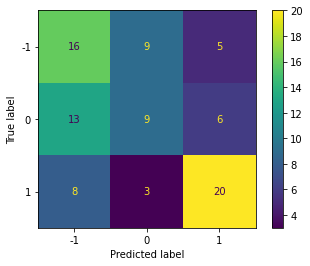

In [13]:
pipe_svc = make_pipeline(
    StandardScaler(), PCA(n_components=15),
    SVC(random_state=1, class_weight='balanced', max_iter=-1))

param_range = [0.05, 0.2, 0.5]
param_grid = [{
    'svc__C': param_range,
    'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'svc__gamma': param_range
}]

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=10)

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='f1_macro',
                  refit=True,
                  cv=skf.split(X_train, y_train),
                  n_jobs=-1,
                  verbose=5)

gs.fit(X_train, y_train)

print("SVM gs", gs.best_score_)
print(gs.best_params_)

gs = gs.best_estimator_

y_pred = gs.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
crep = classification_report(y_test, y_pred)
plot_confusion_matrix(gs, X_test, y_test)
print(crep)
profit(u_test, y_pred)

gsl = SVC(class_weight='balanced',
          gamma=.05,
          C=0.2,
          kernel='rbf',
          max_iter=-1,
          random_state=1,
          probability=True)
gsl.fit(X_train, y_train)

In [14]:
X.shape


(295, 15)

## Slembiskógar

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.6min finished


RF 0.5297619047619048
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Testing Accuracy for Random Forest Test: 57.3%
              precision    recall  f1-score   support

          -1       0.57      0.40      0.47        30
           0       0.47      0.50      0.48        28
           1       0.66      0.81      0.72        31

    accuracy                           0.57        89
   macro avg       0.57      0.57      0.56        89
weighted avg       0.57      0.57      0.56        89

******hagnaður*****
0.3799665332775451
*******************


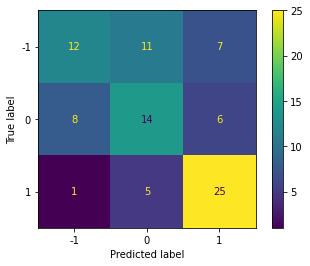

In [15]:
model_params = {
    'n_estimators': [200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_split': [2, 5, 10],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5]
}

pipe_rf = make_pipeline(
    StandardScaler(), PCA(n_components=14),
    RandomForestClassifier(random_state=1,
                           class_weight='balanced',
                           criterion='gini'))

rf_model = RandomForestClassifier(random_state=1,
                                  class_weight='balanced',
                                  criterion='gini')
RFclf = GridSearchCV(rf_model,
                     model_params,
                     cv=skf.split(X_train, y_train),
                     refit=True,
                     verbose=1)

RFclf.fit(X_train, y_train)

print("RF", RFclf.best_score_)
print(RFclf.best_params_)

RFpred = RFclf.predict(X_test)
cm = confusion_matrix(y_test, RFpred)
plot_confusion_matrix(RFclf, X_test, y_test)

print("Testing Accuracy for Random Forest Test: {:.4}%".format(
    RFclf.score(X_test, y_test) * 100))

print(classification_report(y_test, RFpred))
profit(u_test, RFpred)

RF = RFclf.best_estimator_

UFpred = RFclf.predict(X_test1)

## Spár fyrir næsta fjórðung

In [23]:
print("***********************************")
print("***Spá með tilliti til uppgjöra ***")
print("***********************************")

y_pred_xgb = model.predict(X_test1)
y_pred_svm = gs.predict(X_test1)
y_pred_rf = RFclf.predict(X_test1)

i = 0
print("{}\t\t {}{}\t".format("útgefandi".ljust(16), "XGB",
                             "     SVM     RF      "))
for x in X_test1.index:
    print("{}\t\t {}\t {}\t {}\t ".format(x.ljust(18), y_pred_xgb[i],
                                          y_pred_svm[i], y_pred_rf[i]))
    i += 1

***********************************
***Spá með tilliti til uppgjöra ***
***********************************
útgefandi       		 XGB     SVM     RF      	
eik.ic_2021Q1     		 -1	 1	 1	 
eim.ic_2021Q1     		 -1	 -1	 -1	 
brim.ic_2021Q1    		 -1	 1	 -1	 
haga.ic_2021Q1    		 -1	 1	 -1	 
vis.ic_2021Q1     		 -1	 0	 -1	 
tm.ic_2021Q1      		 -1	 1	 -1	 
sjova.ic_2021Q1   		 -1	 1	 -1	 
siminn.ic_2021Q1  		 -1	 0	 1	 
syn.ic_2021Q1     		 -1	 1	 1	 
skel.ic_2021Q1    		 -1	 1	 -1	 
reitir.ic_2021Q1  		 1	 1	 1	 
reginn.ic_2021Q1  		 -1	 1	 1	 
marel.ic_2021Q1   		 -1	 1	 -1	 
iceair.ic_2021Q1  		 1	 1	 1	 
icesea.ic_2021Q1  		 -1	 0	 1	 
festi.ic_2021Q1   		 0	 1	 1	 
origo.ic_2021Q1   		 -1	 1	 1	 
arion.ic_2021Q1   		 0	 1	 0	 
kvika.ic_2021Q1   		 -1	 1	 -1	 


## Shap útreikningar fyrir Newton flokkarann

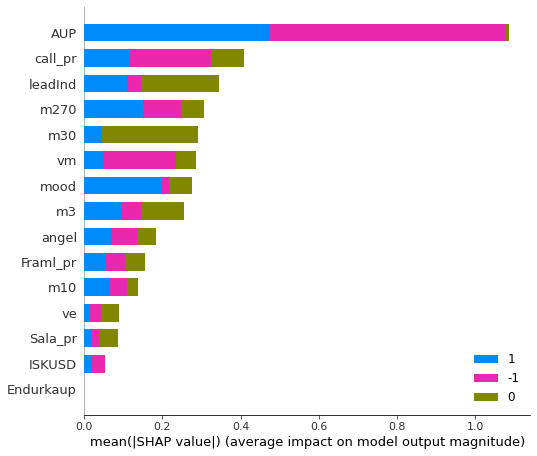

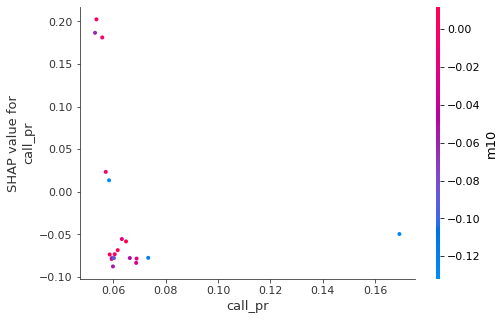

In [17]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test1)

shap.summary_plot(shap_values, X_test1, class_names=model.classes_)
shap.dependence_plot('call_pr', shap_values[1], X_test1)
shap.force_plot(explainer.expected_value[0],
                shap_values[0][13, :],
                X_test1.iloc[13, :].map('{:,.3f}'.format),
                link='logit',
                text_rotation=30)

#shap.force_plot(explainer.expected_value[1], shap_values[1], X_test1)


[0.20097354, 0.70374167, 0.54640025]
[-1  0  1]


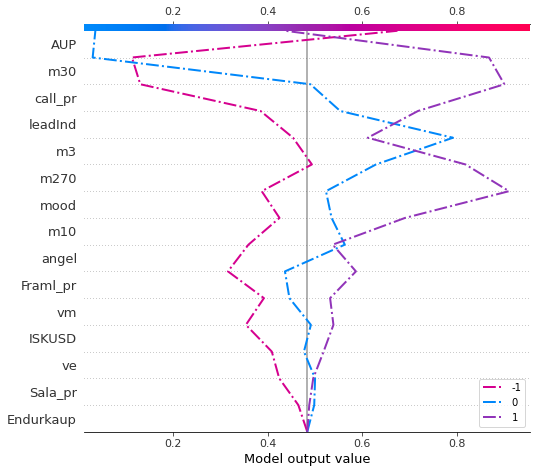

In [18]:
print(explainer.expected_value)
print(model.classes_)

shap_values = explainer.shap_values(X_test1)

idx = 1

r = shap.multioutput_decision_plot(
    explainer.expected_value,
    shap_values,
    idx,
    #feature_order='importance',
    return_objects=True,
    highlight=[y_pred_xgb],
    legend_location='lower right',
    legend_labels=[str(int) for int in model.classes_],
    feature_names=X.columns.tolist())

## Shap útreikningar fyrir sléttuskurðarvélina

In [19]:

sc = StandardScaler()

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)
X_test1_std = sc.transform(X_test)

explainer = shap.KernelExplainer(gsl.predict_proba, X,link='logit' )
shap_values = explainer.shap_values(X, nsamples=100,)

shap.summary_plot(shap_values,
                  X,
                  plot_type='bar',
                  class_names=model.classes_)

shap.plots.beeswarm(shap_values)

Using 295 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyboardInterrupt: 

In [ ]:
idx = 14

instance = X_test1.iloc[idx - 1:idx]
pred = gsl.predict(instance)
scores = gsl.decision_function(instance)
class_idx = pred.item()
print("The predicted class for the X_test1[{}] is {}.".format(idx, *pred))

print("OVR decision function values are {}.".format(*scores))

pred_fcn = gsl.decision_function
np.random.seed(0)
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train_std)
svm_explanation = svm_explainer.explain(X_test1_std, l1_reg=False)

shap.force_plot(svm_explainer.expected_value[class_idx],
                svm_explanation.shap_values[class_idx][idx, :],
                instance,
                feature_names=X.columns.tolist(),
                text_rotation=30,
                link='logit')

r = shap.multioutput_decision_plot(
    svm_explainer.expected_value.tolist(),
    svm_explanation.shap_values,
    idx,
    feature_order='importance',
    highlight=[class_idx],
    return_objects=True,
    legend_location='lower right',
    legend_labels=[str(int) for int in model.classes_],
    feature_names=X.columns.tolist())

## Shap útreikningar fyrir slembitré

In [ ]:
explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(X_test1)
idx = 1
shap.summary_plot(shap_values, X, plot_type='bar', class_names=RF.classes_)

shap.force_plot(explainer.expected_value[0],
                shap_values[0][5, :],
                X.iloc[5, :].map('{:,.3f}'.format),
                text_rotation=30,
                link='logit',
                matplotlib=True)

#shap.force_plot(explainer.expected_value[1],shap_values[1],X_std)

r = shap.multioutput_decision_plot(explainer.expected_value.tolist(),
                                   shap_values,
                                   idx,
                                   feature_order='importance',
                                   return_objects=True,
                                   legend_location='lower right',
                                   feature_names=X.columns.tolist())

## Reiknað með Newton aðhvarfsgreiningu

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y1,
                                                    test_size=test_size,
                                                    random_state=seed)

# Ný D-fylki

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtest1 = xgb.DMatrix(X_test1)

mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape) * mean_train
# Reikna meðal skekkju
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.3f}".format(mae_baseline))

import xgboost as xgb

xgb1 = xgb.XGBRegressor(class_weight='balanced', seed=2)

parameters = {
    'nthread': [0],
    'objective': ['reg:linear'],
    'eval_metric': ["error"],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [6],
    'min_child_weight': [1, 3, 5, 7],
    'silent': [0],
    'subsample': [0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [100, 200, 300]
}

xgb_regressor = GridSearchCV(xgb1, parameters, cv=2, n_jobs=5, verbose=5)

xgb_regressor.fit(X_train, y_train)

print(xgb_regressor.best_score_)
print(xgb_regressor.best_params_)

y_pred = xgb_regressor.predict(X_test)
print("mae", mean_absolute_error(y_test, y_pred))
print("rmse", math.sqrt(mean_squared_error(y_test, y_pred)))
print("r2", r2_score(y_test, y_pred))
print("evs", explained_variance_score(y_test, y_pred))

sum = 0
sumlist = []
for i in range(len(y_pred)):
    if y_pred[i] > thröskuldur:
        sumlist.append(y_test[i])
    elif y_test[i] < -thröskuldur:
        sum = sum + max(-y_test[i] - thröskuldur, 0) * 10
        sumlist.append(y_test[i])
print("***********************************")
print("*************hagnaður**************")
print(sum / len(y_test))
print("************************************")
print("***********************************")
print("***Spá með tilliti til uppgjöra ***")
print("***********************************")

y_pred_xgb = xgb_regressor.predict(X_test1)
#y_pred_svm = gs.predict(X_test1)
predictions = [round(value) for value in y_pred]
i = 0
print("{}\t{}\t".format("útgefandi".ljust(18), "XGB Regressor          |"))
for x in X_test1.index:
    print("{}\t\t{:02.4f}".format(x.ljust(18), y_pred_xgb[i]))
    i += 1

params = xgb_regressor.best_params_
xgb_regressor = xgb.XGBRegressor(**params)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_regressor.fit(X_train,
                  y_train,
                  eval_metric=["mae"],
                  eval_set=eval_set,
                  verbose=False)

results = xgb_regressor.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# plot classification error
fig, ax = plt.subplots()
plt.grid(True, which='major')
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('Error')
plt.show()

## Lærdómsföll

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        axes=None,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes,
                 train_scores_mean,
                 'o-',
                 color="r",
                 label="Training score")
    axes[0].plot(train_sizes,
                 test_scores_mean,
                 'o-',
                 color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes,
                         fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std,
                         alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator,
                    title,
                    X,
                    Y,
                    axes=axes[:, 0],
                    ylim=(0.2, 1.01),
                    cv=cv,
                    n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
estimator = model
plot_learning_curve(estimator,
                    title,
                    X,
                    Y,
                    axes=axes[:, 1],
                    ylim=(0.2, 1.01),
                    cv=cv)

plt.show()